In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm,kstest,shapiro,t
import pylab
import time
import warnings
import seaborn as sns
import statistics
import os
lib_path = os.path.join(os.path.abspath('.'), '..')
sys.path.append(lib_path)
from risk_management.simulation import simulate_path,Return_T_params
warnings.filterwarnings('ignore')

## Problem 1 
Calculate and compare the expected value and standard deviation of price at time $t(𝑃_t)$ , given each of the 3 types of price returns, assuming 𝑟 ~ $N( 0,\sigma^2 )$ . Simulate each return equation using $r_𝑡 ∼ 𝑁 (0, \sigma^2)$ and show the mean and standard deviation match your expectations.

calculate the mean and standard deviation at time t as follows:

1.Classical Brownian Motion
$$P_t = P_0 + r_1...+r_{t-1}$$


$$ E[P_t] = P_0 $$

$$ var[P_t] = 0+var(r_1)+...+var(r_{t-1}) = t*\sigma^2$$

2.Arithmetic

$$P_t = P_0(1+r_1)...(1+r_{t-1})$$

$$ E[P_t] = E[P_{t-1}(1+r_{t-1})] = E[P_{t-1}+P_{t-1}* r_{t-1}] = P_{t-1}$$

$$ var[P_t] = var(P_{t-1}+P_{t-1}* r_{t-1}) = P_{t-1}^2 *\sigma$$

3.Geometric Brownian Motion

$$ Ln(P_t) \sim N(\mu+ ln(P_t), \sigma^2)$$

In [51]:
from numpy import *
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    # Read parameters
    S0 = s0         # initial spot level
    r = mu          # mu = rf in risk neutral framework 
    T = horizon     # time horizion
    t = timesteps   # number of time steps
    n = n_sims      # number of simulation
    
    # Define dt
    dt = T/t        # length of time interval  
    
    # Simulating 'n' asset price paths with 't' timesteps
    S = zeros((t, n))
    S[0] = S0

    for i in range(0, t-1):
        w = random.standard_normal(n)                                                        # psuedo random numbers
        S[i+1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * w)                                  # vectorized operation per timesteps
        # S[i+1] = S[i] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * w)            # alternate form
        
    return S

simulate_path(100, 0, 0.1, 1, 100, 1000)[-1].mean()


100.2013427683328

In [89]:
class PriceSimulator():
    """
    A Brownian motion class constructor
    """
    def __init__(self,S=100,mu=0, sigma=0.01):
        "path: # of simulation paths"
        self.S=S
        self.mu = mu
        self.sigma = sigma
    

    def simulate(self,method = "Brownian",path=0,known_step=100,nOfDarws = 1000):
        
        # calculate the each path in Brownian method
        def BrownianPath(start, N):
            """
            Models a stock price S(t) using the Classical Brownian Motion as
            S(t) = S(t-1) + rt
            rt ~ N(0, 𝜎2)
            """
            positions = np.zeros(N)
            for y in range(N):
                positions[y] = start
                start = start + np.random.normal(self.mu, self.sigma)

            return positions

        # calculate the each path in  method
        def ArithmeticPath(start, N):
            """
            Models a stock price S(t) using the Arithmetic Return System as
            S(t) = S(t-1) (1 + rt)
            rt ~ N(0, 𝜎2)
            """
            positions = np.zeros(N)
            for y in range(N):
                positions[y] = start
                start = start*(1+np.random.normal(self.mu, self.sigma))

            return positions

        # calculate the each path in Geo Brownian method
        def GeoBrownianPath(start, N):
            """
            Models a stock price S(t) using the Geometric Brownian Motion as
            S(t) = S(t-1)*e^rt
            rt ~ N(0, 𝜎2)
            """
            positions = np.zeros(N)
            for y in range(N):
                positions[y] = start
                start = start*np.exp(np.random.normal(self.mu, self.sigma))

            return positions

        """
        Arguments:
            method: Brownian, Arithmetic, GeoBrownian

        Returns:
            simulation_bm: DataFrame of stock prices simulations
        """
        simulation_bm = pd.DataFrame()
        if method=="Brownian":
            Ft_routine = BrownianPath(self.S, known_step)
        elif method=="Arithmetic":
            Ft_routine = ArithmeticPath(self.S,known_step)
        elif method=="GeoBrownian":
            Ft_routine = GeoBrownianPath(self.S, known_step)
        else:
            raise ValueError("no such method!")
            
        if len(Ft_routine)==0:
            k_start = self.S
        else:
            k_start = Ft_routine[-1]
        
        for x in range(path):
            if method=="Brownian":
                Fs_routine = BrownianPath(k_start, nOfDarws)
            elif method=="Arithmetic":
                Fs_routine = ArithmeticPath(k_start, nOfDarws)
            elif method=="GeoBrownian":
                Fs_routine = GeoBrownianPath(k_start, nOfDarws)

            allPath = np.hstack((Ft_routine,Fs_routine))
            simulation_bm[x] = allPath
            self.simulation_bm = simulation_bm
        return simulation_bm
    


p = 5000
knownN = 0
simuN = 100
sigma = 0.05

simulator = PriceSimulator(100,0,sigma)
simu1 = simulator.simulate("Brownian",1000,knownN,simuN)
simu2 = simulator.simulate("Arithmetic",1000,knownN,simuN)
simu3 = simulator.simulate("GeoBrownian",1000,knownN,simuN)
simu = [simu1,simu2,simu3]


In [92]:
price_t1 = simu1.iloc[knownN,:][0]
mean1 = np.mean(simu1.iloc[-1,:])
var1 = statistics.stdev(simu1.iloc[-1,:])

price_t2 = simu2.iloc[knownN,:][0]
mean2 = np.mean(simu2.iloc[-1,:])
var2_log = statistics.stdev(np.log(simu2.iloc[-1,:]))

price_t3 = simu3.iloc[knownN,:][0]
mean3 = np.mean(simu3.iloc[-1,:])
var3_log = statistics.stdev(np.log(simu3.iloc[-1,:]))
titles = ["Brownian","Arithmetic","GeoBrownian"]
stat = pd.DataFrame([[price_t1, mean1, np.sqrt(simuN) * sigma, var1],
                    [price_t2,mean2,np.sqrt(simuN) * sigma, var2_log],
                    [price_t3,mean3,np.sqrt(simuN) * sigma, var3_log]
                    ],
                   columns = ["Start Price","End Price Mean","Expected sigma", "End Price SD"],
                   index = titles)
stat

,Start Price,End Price Mean,Expected sigma,End Price SD
Brownian,100.0,99.974815,0.5,0.504323
Arithmetic,100.0,96.267464,0.5,0.488328
GeoBrownian,100.0,112.611132,0.5,0.483460


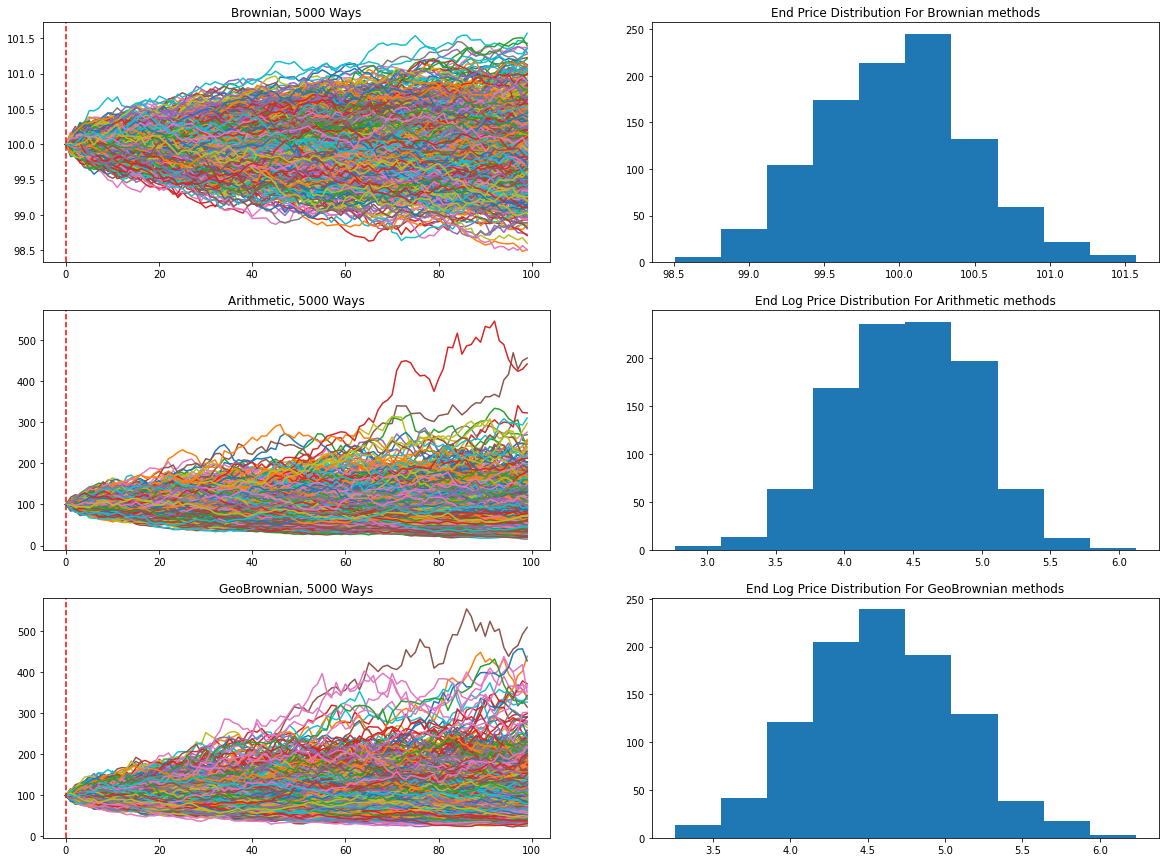

In [93]:

fig, axes = plt.subplots(3,2,figsize = (20,15))
for i in range(3):
    axes[i][0].plot(simu[i])
    axes[i][0].set_title(f"{titles[i]}, {p} Ways")
    axes[i][0].axvline(x = knownN, ls = "--",c = "r")
    final_p = simu[i].iloc[-1,:]
    if i==0:
        axes[i][1].hist(final_p)
        axes[i][1].set_title(f"End Price Distribution For {titles[i]} methods")
    else:
        axes[i][1].hist(np.log(final_p))
        axes[i][1].set_title(f"End Log Price Distribution For {titles[i]} methods")

In [94]:
stat

,Start Price,End Price Mean,Expected sigma,End Price SD
Brownian,100.0,99.974815,0.5,0.504323
Arithmetic,100.0,96.267464,0.5,0.488328
GeoBrownian,100.0,112.611132,0.5,0.483460


## Conclusion
At known moments, the future stock prices is only relevant to the present moment's price.

The mean of the stock price at time T in the future is normal distribution when applying the Classical Brownian Motion, but lognormally distributed when applying the Arithmetic and Geometric Brownian Motion. The price volatility at time T will accumulate over time at a speed of square root of T.

## Problem 2
Implement a function similar to the “return_calculate()” in this week’s code. Allow the user to specify the method of return calculation. 

Use DailyPrices.csv. Calculate the arithmetic returns for INTC. Remove the mean from the series so that the mean(INTC)=0.

Calculate VaR 
1. Using a normal distribution. 
2. Using a normal distribution with an Exponentially Weighted variance (λ = 0. 94) 
3. Using a MLE fitted T distribution. 
4. Using a Historic Simulation. Compare the 4 values. Look at the empirical distribution of returns, in sample. Download from Yahoo! Finance the prices since the end of the data in the CSV file (about 2 weeks). Look the empirical distribution of returns, out of sample.

Discuss the ability of these models to describe the risk in this stock.

In [95]:
def return_calculate(data):
    return data.pct_change().dropna()

In [96]:
df = pd.read_csv("DailyPrices.csv")
ret = return_calculate(df["INTC"])
ret -= ret.mean()
ret = pd.DataFrame(ret)
sigma = ret.std()

In [97]:
sigma

INTC    0.020936
dtype: float64

## normal distribution

In [98]:
#normal distribution
#from scipy.stats import norm,t
simu_norm = np.random.normal(0,sigma,size=10000)

VaR1 = -np.percentile(simu_norm,5)
print(f"Normal distribution VaR: {round(VaR1*100,2)}%")


Normal distribution VaR: 3.48%


## normal distribution with an Exponentially Weighted variance (λ = 0. 94)

In [99]:
def calculate_weight(lamb, df):
    X = df.index.values
    weight = [(1-lamb)*lamb**(i-1) for i in X]
    weight_adjust = [weight[i]/sum(weight) for i in X]
    return weight_adjust

def weighted_pair(x, y, weight):
    n = len(weight)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    cov = 0
    for i in range(n):
        cov += weight[n - 1 - i]*(x[i] - mean_x) * (y[i] - mean_y)
    return cov

# calculate the weigted variance
temp = ret.reset_index()
weight = calculate_weight(0.94,temp)
w_sigma = np.sqrt(weighted_pair(ret.values, ret.values, weight))
simu_Wnorm = np.random.normal(0,w_sigma,10000)
VaR2 = -np.percentile(simu_Wnorm,5)
print(f"Exponentially Weighted Normal VaR: {round(VaR2*100,2)}%")

Exponentially Weighted Normal VaR: 2.67%


## MLE fitted T distribution

In [118]:
t_params = Return_T_params(ret)
simu_T =  t.rvs(df = t_params[0],loc = t_params[1],scale = t_params[2],size = 10000)
VaR3 = -np.percentile(simu_T,5)
print(f"T distribution VaR: {round(VaR3*100,2)}%")

T distribution VaR: 2.65%


## Historic Simulation

In [102]:
VaR4 = -np.percentile(ret,5)
print(f"Historic Simulation VaR: {round(VaR4*100,2)}%")

Historic Simulation VaR: 2.07%


## Out of sample VaR

In [103]:
import yfinance as yf
intc_df = yf.download('INTC', 
                      start='2022-01-05', 
                      end='2022-02-11', 
                      progress=False,
)
intc_df = intc_df["Adj Close"]
ret_oos = return_calculate(intc_df)
VaR5 = -np.percentile(ret_oos,5)
print(f"OOS VaR: {round(VaR5*100,2)}%")

OOS VaR: 2.85%


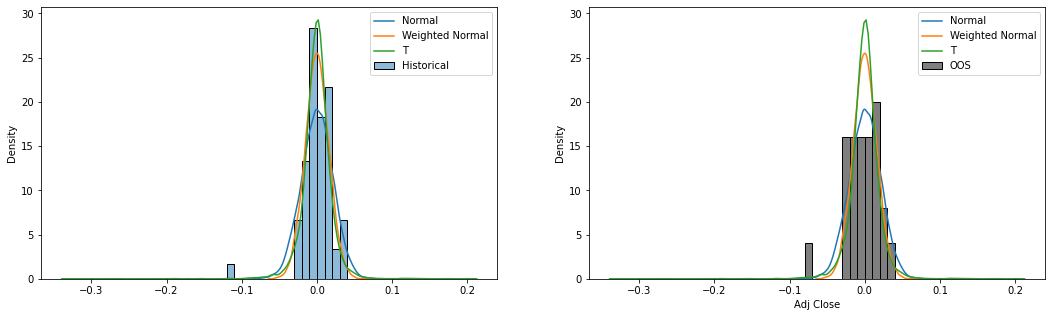

In [104]:
# Discuss the ability of these models to describe the risk in this stock.
fig, axes = plt.subplots(1, 2,  figsize=(18,5))
sns.histplot(ret, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes[0], label='Historical', color='b', alpha=0.5)
sns.distplot(simu_norm, ax=axes[0], hist=False, label='Normal')
sns.distplot(simu_Wnorm, ax=axes[0], hist=False, label='Weighted Normal')
sns.distplot(simu_T, ax=axes[0], hist=False, label='T')
axes[0].legend()

sns.histplot(ret_oos, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes[1], label='OOS', color='black', alpha=0.5)
sns.distplot(simu_norm, ax=axes[1], hist=False, label='Normal')
sns.distplot(simu_Wnorm, ax=axes[1], hist=False, label='Weighted Normal')
sns.distplot(simu_T, ax=axes[1], hist=False, label='T')
axes[1].legend()

In [105]:
var_pd = pd.DataFrame([VaR1,VaR2,VaR3,VaR4,VaR5],index = ["Normal","W Normal","T","Historical","OOS"],columns = ["VaR"])
round(var_pd,4)

,VaR
Normal,0.0348
W Normal,0.0267
T,0.0285
Historical,0.0207
OOS,0.0285


# Conclusion

From the comparison of histogram and VaR dataframe, The most unreliable method is to directly use historical data to predict future VaR. 
So using Monte Carlo simulation to simulate the VaR is a better method. We applied Normal, Exponentially Weighted Normal and T distribution to simulate the future return data. We can see that the return rate of the financial market has the fat-tail characteristic, which indicates drastic fluctuations sometimes happen. Therefore, when predicting risks, the normal distribution can better consider the tail risk.

# Problem 3
Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0. This file contains the stock holdings of 3 portfolios. You own each of these portfolios. Calculate the VaR of each portfolio as well as your total VaR (VaR of the total holdings). Discuss your methods, why you chose those methods, and your results.

In [16]:
def DeltaNormVaR(portfolio, price, alpha=0.05):
    """
    params: portfolio: a DataFrame with 3 columns: [Portfolio, Stock, Holding]
    price: a DataFrame contains all stock price with ascending time series. Index is the time, Column is the Stock name
    """
    portfolio = portfolio.set_index('Stock')
    last_price=pd.DataFrame({"price":price.iloc[-1]})
    portfolio = portfolio.join(last_price.loc[portfolio.index])
    portfolio["value"] = portfolio['Holding']*portfolio['price']
    presentValue = portfolio['value'].sum()
    portfolio["weight"] = portfolio["value"]/presentValue
    weight = portfolio["weight"]
    
    
    ret_all = return_calculate(price)
    port_sigma = np.sqrt(weight.T@ret_all[portfolio.index].cov()@weight)
    
    return -presentValue*port_sigma*norm.ppf(alpha)
    
    

In [17]:
def HistoricalVaR(portfolio, price, alpha=0.05):
    portfolio = portfolio.set_index('Stock')
    last_price=pd.DataFrame({"price":price.iloc[-1]})
    portfolio = portfolio.join(last_price.loc[portfolio.index])
    His_values = price[portfolio.index]@portfolio['Holding']
    ret = His_values.diff().dropna()
    return -np.percentile(ret,alpha*100)


In [18]:
port = pd.read_csv("Portfolio.csv")
port[port["Portfolio"]=="A"]
total = port.groupby('Stock').sum('Holding')
total['Portfolio'] = 'total'
total.reset_index(inplace=True)
port = port.append(total)

prices = pd.read_csv("DailyPrices.csv",index_col=0)
ret_all = return_calculate(prices)
current = pd.DataFrame({"Price":prices.iloc[-1]})


In [22]:
port_data

,Portfolio,Holding,Price,Value,Weight
Stock,,,,,
AAPL,total,58,173.070007,10038.060425,0.009860
ABBV,total,74,135.869995,10054.379639,0.009876
ABT,total,79,128.160004,10124.640289,0.009945
ACN,total,29,353.359985,10247.439575,0.010066
ADBE,total,20,520.599976,10411.999512,0.010228
...,...,...,...,...,...
VZ,total,188,53.279999,10016.639771,0.009839
WFC,total,173,58.060001,10044.380238,0.009866
WMT,total,69,145.059998,10009.139832,0.009832


,A,B,C,Total
DeltaNormVaR,6003.221298,4886.596042,3679.556069,14100.550125
Historical_VaR,5610.072337,5664.361566,3163.626064,12697.538762


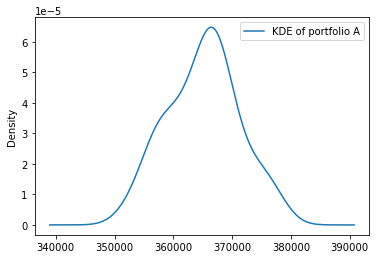

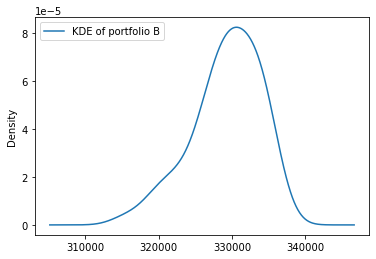

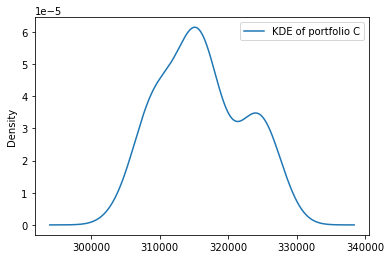

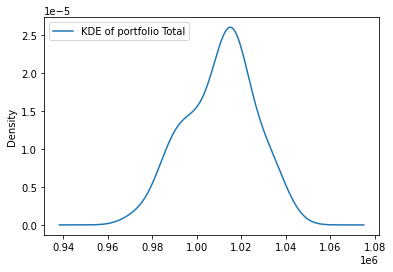

In [19]:
title = ["A","B","C","Total"]
DeltaNorm_VaR = []
His_VaR = []
i=0
for port_name, port_data in port.groupby('Portfolio'):
    DeltaNorm_VaR.append(DeltaNormVaR(port_data, prices))
    His_VaR.append(HistoricalVaR(port_data, prices))
    port_data = port_data.set_index('Stock')
    port_data = port_data.join(current.loc[port_data.index])

    # calculate the value and weight of each asset
    port_data['Value'] = port_data['Holding'] * port_data['Price']
    port_data['Weight'] = port_data['Value'] / sum(port_data['Value'])
    port_value = port_data['Value'].sum()
    

    his_val = prices[port_data.index]@port_data['Holding']


    

    d = pd.DataFrame(his_val,columns = ["KDE of portfolio " + title[i]])
    d.plot.kde()
    # Using a KDE to smooth the VaR estimation

    
    i+=1
    
pd.DataFrame({"DeltaNormVaR":DeltaNorm_VaR,
             "Historical_VaR":His_VaR},index =title).T

## Conclusion
Due to the returns are not normally distributed and asset prices are not always linear, Financial market has the characteristic of fat tail and often receives the influence of emergencies. Moreover, our historical data is not enough for us to judge the state of all market risks. So we use KDE to optimize the VaR calculation.